## importação das bibliotecas

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import keras 
from tensorflow.keras.applications import ResNet50
%matplotlib inline
import matplotlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras import regularizers


### Carregamento do conjunto de dados de treinamento

In [2]:
# mostrar a quantidade de imagens e classes de treinamento 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    
    "../data/train",
    
    image_size=(180, 180),  # Definir o tamanho das imagens
    
    batch_size=16 # quantidade de imagens por lote 

)

Found 3391 files belonging to 6 classes.


In [3]:
# mostrar o nome das classes
nomes_classes = dataset.class_names
nomes_classes

['Apple', 'Banana', 'Grape', 'Mango', 'Orange', 'Strawberry']

In [4]:
# Contar a quantidade de imagens por classe
class_counts = {class_name: 0 for class_name in dataset.class_names}

for images, labels in dataset:
    for label in labels:
        class_name = dataset.class_names[label]
        class_counts[class_name] += 1

# Exibir a quantidade de imagens por classe
for class_name, count in class_counts.items():
    print(f'A classe {class_name} tem {count} imagens')

# Exibir a quantidade total de classes
num_classes = len(dataset.class_names)
print(f'Total de classes: {num_classes}')

# Exibir a quantidade total de imagens
total_images = sum(class_counts.values())
print(f'Total de imagens: {total_images}')

# Exibir a porcentagem de imagens por classe
for class_name, count in class_counts.items():
    percentage = (count / total_images) * 100
    print(f'A classe {class_name} tem {percentage:.2f}% das imagens')

A classe Apple tem 552 imagens
A classe Banana tem 601 imagens
A classe Grape tem 517 imagens
A classe Mango tem 633 imagens
A classe Orange tem 460 imagens
A classe Strawberry tem 628 imagens
Total de classes: 6
Total de imagens: 3391
A classe Apple tem 16.28% das imagens
A classe Banana tem 17.72% das imagens
A classe Grape tem 15.25% das imagens
A classe Mango tem 18.67% das imagens
A classe Orange tem 13.57% das imagens
A classe Strawberry tem 18.52% das imagens


### Visualização dos dados 

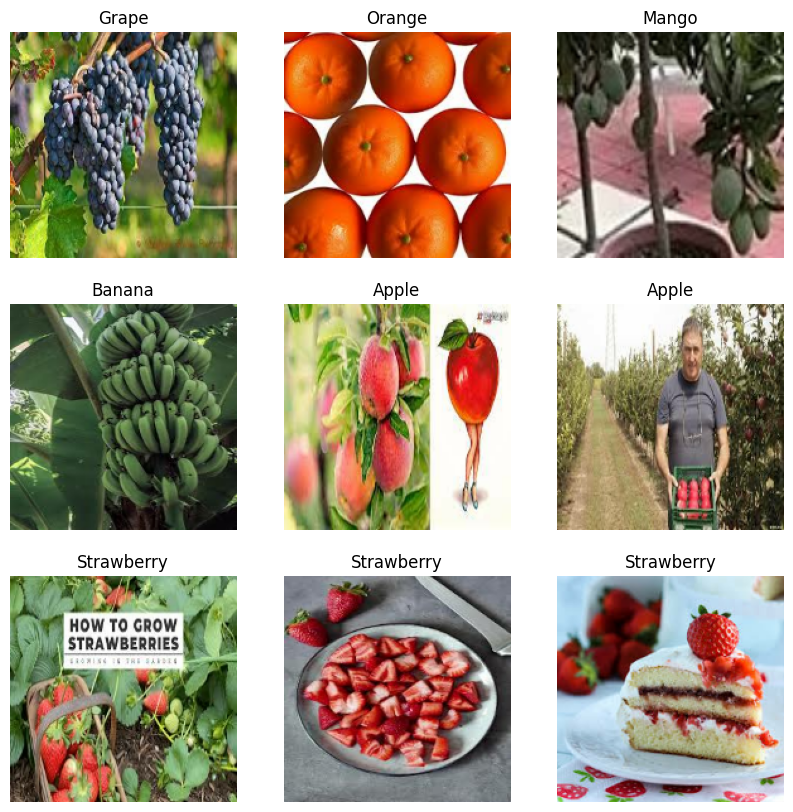

In [5]:
plt.figure(figsize=(10, 10))

for images, labels in dataset.take(1):  # Pegar um lote de imagens
    
    for i in range(9):  # Mostrar as primeiras 9 imagens
        
        ax = plt.subplot(3, 3, i + 1) # exibição das imagens 3X3
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        plt.title(nomes_classes[labels[i]]) # para mostrar o nome da classe
        
        plt.axis("off")
        
plt.show()

### Dados de treinamento e de validação 

In [6]:
# Definindo image_size e batch_size
image_size = (180, 180)
batch_size = 32

# Caminhos para os dados de treinamento e validação
treinamento_data = "../data/train"
validacao_data = "../data/valid"
test_data = "../data/test"

# Carregando os datasets
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    treinamento_data,
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    validacao_data,
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

test_data_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_data,
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

Found 3391 files belonging to 6 classes.
Found 226 files belonging to 6 classes.
Found 157 files belonging to 6 classes.


### Modelo RESNET 

In [7]:
# Definir a função get_model
def get_model(num_classes):
    
    base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
    
    for layer in base_model.layers:
    
        layer.trainable = False
    
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    
    x = keras.layers.Dense(256, activation='relu')(x)
    
    outputs = keras.layers.Dense(num_classes)(x)
    
    model = keras.Model(inputs=base_model.input, outputs=outputs)
    
    return model

# Criar e compilar o modelo
model = get_model(num_classes)
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy']
)


### Data Augmentation

 testar somente depois

In [9]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_augmented = datagen.flow_from_directory(
    '../data/train',
    target_size=(180, 180),
    batch_size=batch_size,
    class_mode='sparse'
)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Found 3391 images belonging to 6 classes.


### Treinamento do modelo 

In [10]:
# Treinamento do modelo
history = model.fit(
    train_data_augmented,
    epochs=20,
    validation_data=val_data,
    callbacks=[early_stopping]
)

Epoch 1/20


c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


106/106 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5632 - loss: 1.3613 - val_accuracy: 0.7434 - val_loss: 0.6696
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.7869 - loss: 0.5851 - val_accuracy: 0.7743 - val_loss: 0.6013
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.8438 - loss: 0.4527 - val_accuracy: 0.8097 - val_loss: 0.5657
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.8474 - loss: 0.4027 - val_accuracy: 0.8142 - val_loss: 0.6430
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.8863 - loss: 0.3211 - val_accuracy: 0.8097 - val_loss: 0.5504
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8948 - loss: 0.2851 - val_accuracy: 0.8053 - val_loss: 0.5888
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.9032 - loss: 0.2675 - val_accuracy: 0.8053 - val_loss: 0.5652
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9198 - loss: 0.2234 - val_accuracy: 0.796

### Salvar o modelo

In [11]:
with open('../models/history1.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [12]:
model.save('../models/modelo1.h5')

In [13]:
from tensorflow.keras.models import load_model

modelo1 = load_model('../models/modelo1.h5')

### Histórico do modelo

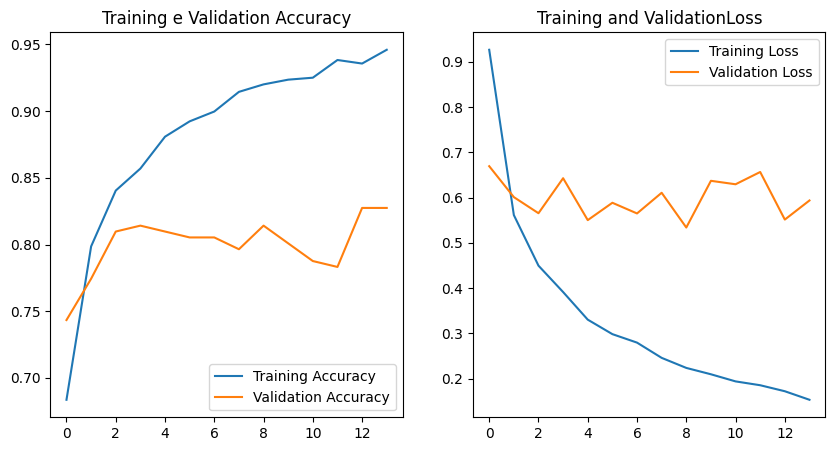

In [17]:
# mostrar o historico de treinamento


accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(14)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training e Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and ValidationLoss')

plt.show()

### Validação do modelo 

In [ ]:
# avaliar o modelo

test_loss, test_acc = model.evaluate(dataset, verbose=2)

print('\nTest accuracy:', test_acc)

print('\nTest loss:', test_loss)

In [26]:
# Carregando o conjunto de dados de validação
validacao_data = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/valid",
    label_mode='int',
    batch_size=32,
    image_size=(180, 180),
    shuffle=False
)

Found 226 files belonging to 6 classes.


Ajustar hiperparâmetros e arquitetura do modelo.
- aumentar a quantidade de parÂmetros para diminuir o overfitting

Aumentar o conjunto de dados para melhorar a precisão.

Utilizar técnicas de aumento de dados para melhorar a robustez do modelo.

## Matriz de confusão 

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


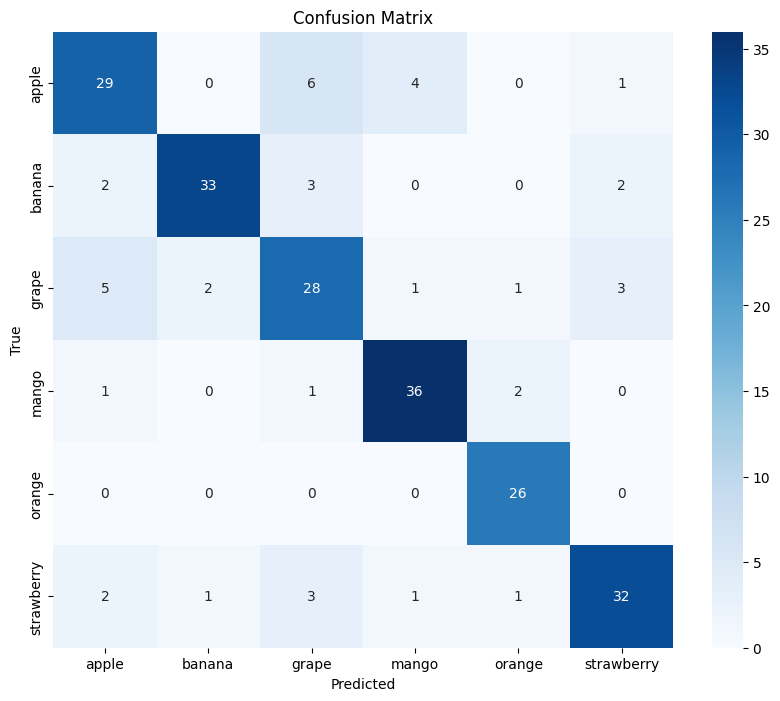

Classification Report:
              precision    recall  f1-score   support

       apple       0.74      0.72      0.73        40
      banana       0.92      0.82      0.87        40
       grape       0.68      0.70      0.69        40
       mango       0.86      0.90      0.88        40
      orange       0.87      1.00      0.93        26
  strawberry       0.84      0.80      0.82        40

    accuracy                           0.81       226
   macro avg       0.82      0.83      0.82       226
weighted avg       0.82      0.81      0.81       226



In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Definindo manualmente os nomes das classes (substitua com suas classes reais)
class_names = ['apple', 'banana', 'grape', 'mango', 'orange', 'strawberry']

# Fazendo previsões no conjunto de teste
y_pred = model.predict(validacao_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtendo os rótulos reais do conjunto de teste
y_true = np.concatenate([y for _, y in validacao_data], axis=0)

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotando a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Relatório de classificação
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)
